# Cannabis legalization effects on hard drugs trafficking and usage
#### By Nardine Abu-Nassar and Arie Stoliarsky

---

# Data preprocessing
## Section 1: packages import


In [26]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mutual_info_score

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## Section 2: load the datasets

---

#### sub-sections:
2.1) Download files:<BR>
    &emsp;2.1.1) From the [UNODC site](https://www.unodc.org/unodc/en/data-and-analysis/wdr2024-annex.html):<BR>
    &emsp;&emsp;2.1.1.a) 7.1._Drug_seizures_2018-2022.xlsx<BR>
    &emsp;&emsp;2.1.1.b) 10.1._Drug_related_crimes.xlsx<BR>
    &emsp;2.1.2) From Kaggle download the [legalization status dataset](https://www.kaggle.com/datasets/venusrosario/legality-of-cannabis/)     <BR>

2.2) Change the names for our ease of use:<BR>
    &emsp;2.2.1) 7.1._Drug_seizures_2018-2022.xlsx --> unodc_drug_seizures.xlsx<BR>
    &emsp;2.2.2) 10.1._Drug_related_crimes.xlsx --> unodc_drug_crime_counts.xlsx<BR>
    &emsp;2.2.3) Legality_of_cannabis.csv --> legalization.csv<BR>

2.3) Manual feature engineering - further explanation in [section 3](#section-3-manual-feature-engineering-for-legalizationcsv)

2.4) Load data into pandas Dataframes


In [3]:
# Defining constants
data_path = Path(f"{os.getcwd()}\\data\\")

# rename files
if os.path.isfile(data_path.joinpath('7.1._Drug_seizures_2018-2022.xlsx')):
    os.rename(data_path.joinpath('7.1._Drug_seizures_2018-2022.xlsx'), data_path.joinpath('unodc_drug_seizures.xlsx'))
if os.path.isfile(data_path.joinpath('10.1._Drug_related_crimes.xlsx')):
    os.rename(data_path.joinpath('10.1._Drug_related_crimes.xlsx'), data_path.joinpath('unodc_drug_crime_counts.xlsx'))
if os.path.isfile(data_path.joinpath('Legality_of_cannabis.csv')):
    os.rename(data_path.joinpath('Legality_of_cannabis.csv'), data_path.joinpath('legalization.csv'))


In [4]:
# load into pandas DataFrame:
seizures_df = pd.read_excel(data_path.joinpath('unodc_drug_seizures.xlsx'), header=1, engine='calamine')
seizures_df.head()

,Region,SubRegion,Country,DrugGroup,DrugSubGroup,DrugName,Reference year,Kilograms,msCode
0,Africa,East Africa,Kenya,Amphetamine-type stimulants (excluding “ecstasy”),Methamphetamine,Methamphetamine,2022,10.84,KEN
1,Africa,East Africa,Kenya,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),Cannabis herb (marijuana),2022,8474.41,KEN
2,Africa,East Africa,Kenya,Cannabis-type drugs (excluding synthetic canna...,Cannabis plants,Cannabis plants,2022,2534.40,KEN
3,Africa,East Africa,Kenya,Cocaine-type,Cocaine,Cocaine hydrochloride,2022,10.99,KEN
4,Africa,East Africa,Kenya,Opioids,Opiates,Heroin,2022,38.94,KEN


In [5]:
crime_counts_df = pd.read_excel(data_path.joinpath('unodc_drug_crime_counts.xlsx'), engine='calamine')
crime_counts_df.head()

,Region,SubRegion,Country,campaign,Year,Type of offence,Drug,Calculated total,Reported total,Males,Females,Adults,Juveniles,Unknown/Other/ Third/Intersex,Specify year if other,Adults: 18 and older,Juveniles: under 18 years old,msCode
0,Africa,West and Central Africa,Ghana,ARQ2021,2021,Other drug-related offences,Any Illicit drugs,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Yes,Yes,GHA
1,Europe,Western and Central Europe,Gibraltar,ARQ2021,2021,Other drug-related offences,Any Illicit drugs,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,GIB
2,Asia,East and South-East Asia,"China, Macao SAR",ARQ2021,2021,Other drug-related offences,Any Illicit drugs,0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,Yes,Yes,MAC
3,Americas,South America,Venezuela (Bolivarian Republic of),ARQ2022,2022,Other drug-related offences,Any Illicit drugs,0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,Yes,Yes,VEN
4,Africa,North Africa,Algeria,HIST2018,2018,Offences related to drug trafficking,Other opioids not under international control,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Yes,DZA


In [6]:
legalization_df = pd.read_csv(data_path.joinpath('legalization.csv'), encoding='utf-16')
legalization_df.head()

,Country/Territory,Recreational,Recreational_year,Medical,Mediacal_year,Decriminalized_max_possession,Notes
0,Afghanistan,Illegal,NaN,Illegal,NaN,NaN,Production banned by King Zahir Shah in 1973.
1,Albania,Illegal,NaN,Legal,2023.0,NaN,Prohibited but plants highly available through...
2,Algeria,Illegal,NaN,Illegal,NaN,NaN,NaN
3,Andorra,Illegal,NaN,Illegal,NaN,NaN,NaN
4,Angola,Illegal,NaN,Illegal,NaN,NaN,NaN


---

## Section 3: Manual feature engineering for legalization.csv

There was crucial information missing - the years when legislation had changed.
Therefore, using the **Notes** column, which contains diverse information, including years when countries changed legislation.
Additionally, it contains data about the maximum amount of cannabis that a citizen can have on his possession without receiving a penalty (in grams).

As such, we manually had created three new columns - *Recreational_year* (integer) and *Medical_year* (integer) which indicate the year the legislation
was enacted in, according to of our category, and *Decriminalized_max_possession* (float) that indicates the maximum amount of possession of cannabis on a person is allowed in a country (in grams).

We validated our manual work with reference to other Wikipedia pages and Google's Gemini for further consultation.

---

## Section 4: Initial analysis of each dataframe

### sub-section 4.1: _unodc_seizures_

#### Key features:

- Region (as a way to aggregate countries)
- Country (as a key to merge between datasets, and as the most basic geographical entity)
- DrugGroup (mainly used to merge this dataset with the drug_crime dataset)
- DrugSubGroup (as an indicator of the drug type)
- Reference Year (for the timeseries analysis)
- Kilograms (our target variable)

Accordingly - the following features will be dismissed:
- SubRegion (less known than continent, and region is a good enough aggregate) - However it does help us differentiate between North, Central and South America.
- DrugName (too specific, making the number of categories too large - see figure 4.1.1)
- msCode (another way of writing the country's name)

#### 4.1.1 - drug type categorization (_DrugName_, _DrugGroup_, _DrugSubGroup_ variables)

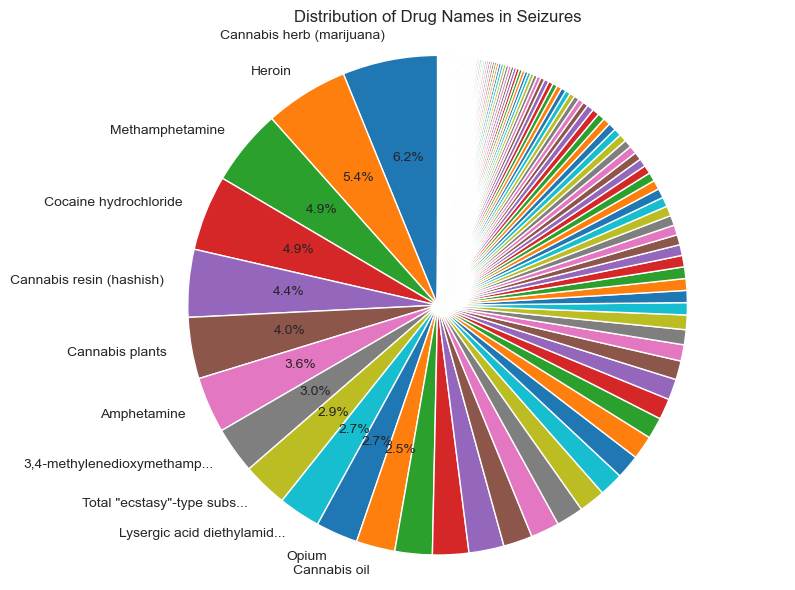

In [7]:
# extract the drug names and their counts
drugNames = seizures_df["DrugName"].value_counts()

# Calculate percentages
total = drugNames.sum()
percentages = 100 * drugNames / total

# Create shortened labels
MAX_LABEL_LENGTH = 25
labels = []
for drug_name, pct in zip(drugNames.index, percentages):
    if pct >= 2.5:  # Only show labels for segments ≥ 2.5%
        # Truncate long labels
        if len(drug_name) > MAX_LABEL_LENGTH:
            labels.append(drug_name[:MAX_LABEL_LENGTH] + "...")
        else:
            labels.append(drug_name)
    else:
        labels.append('')  # Empty string for small segments

# Create a figure
plt.figure(figsize=(8, 6))

# Create pie chart with truncated labels
plt.pie(drugNames.values,
        labels=labels,
        autopct=lambda pct: f'{pct:.1f}%' if pct >= 2.5 else '',
        startangle=90)

# Equal aspect ratio ensures the pie chart is circular
plt.axis('equal')

# Add title
plt.title('Distribution of Drug Names in Seizures')

# Show plot
plt.tight_layout()
plt.show()


As it can be seen in the pie-chart above, the distribution of drug types is almost uniform, and contains a large variety of values. Thus, making this variable less informative that its higher-level counterpart _DrugSubGroup_ a more viable candidate than it.

On the other hand, as it could be observed below, using only _DrugGroup_ is too general, for example - it aggregates different types of cannabis type drugs together, some of them don't apply under the legalization status in most cases (i.e. Hashish). Therefore, making _DrugSubGroup_ an essential variable for indicating the drug type category.

To handle the removal of this feature, we are going to aggregate _Kilograms_ by summing it for all _DrugNames_.

#### 4.1.2: Selecting sub-group of hard drugs to use in our study

This is going to be achieved by counting for each _DrugGroup_ the amount of instances in our dataset

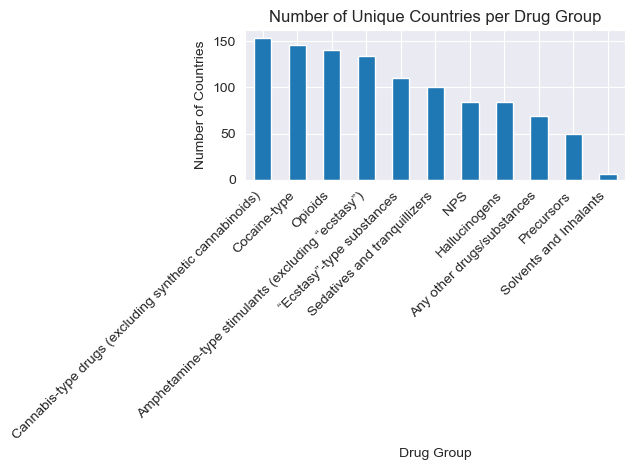

In [8]:
# Count unique countries per drug group
country_counts = seizures_df.groupby('DrugGroup')['Country'].nunique().sort_values(ascending=False)

# Plot the bar chart
plt.figure()
country_counts.plot(kind='bar')
plt.xlabel('Drug Group')
plt.ylabel('Number of Countries')
plt.title('Number of Unique Countries per Drug Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

From the bar-plot above, we can see that except cannabis-type, which are considered _light_ drugs, all other types between Cocaine and Hallucinogens will be considered in out case (with one exception).

The following drugs are dismissed:
- *Any other drugs/substances*: It is too general, and we cannot determine whether these substances are considered hard drugs.
- *Percursors* and *Solvents and Inhalants*: There is more than half the countries which don't gather data on these, and the countries that do gather data on them are insignificant to our analysis.
- *NPS*: This is the UNODCs definition of NPS:


> A New Psychoactive Substance (NPS) is a substance of abuse, either in a pure form or a
> preparation, that is not controlled by the 1961 Single Convention on Narcotic Drugs or the
> 1971 Convention on Psychotropic Substances, but which may pose a “public health threat”. In
> this context, the term “new” does not necessarily refer to novel inventions but to substances
> that have recently become available.
> Since their emergence, NPS have been known in the market by terms such as "designer drugs",
> "legal highs", "herbal highs", and/or "bath salts". The term “designer drugs” had been
> traditionally used to identify synthetic substances. However, it has recently been broadened
> to include other psychoactive substances that mimic the effects of illicit and prescription
> drugs.

This category consists of the drugs listed below. As it can be seen, it comprised of various types of drugs like synthetic cannabinoids, mushrooms and Ketamine, all from seemingly different categories (mushrooms are hallucinogens, Khat is as light as cannabis or even close to tobacco, etc.). Additionally, by the definition above, these substances are hard enough to define, **therefore we are going to truncate these rows.**

In [9]:
nps = seizures_df[seizures_df["DrugGroup"] == "NPS"]["DrugName"].value_counts()
nps

DrugName
Ketamine and phencyclidine-type substances    194
Khat                                          104
Synthetic cathinones                           51
Synthetic cannabinoids (“Spice”)               49
Mushrooms (hallucinogenic)                     38
Kratom (Mitragyna speciosa)                    37
Synthetic cannabinoids (Spice)                 29
Non-specified NPS                              13
Alpha-Pyrrolidinohexiophenone (alpha-PHP)      12
Phenethylamines                                12
2C (psychedelics)                               9
Salvia divinorum                                9
Piperazines                                     8
MDMB-CHMICA                                     7
Ayahuasca                                       7
Tryptamines                                     6
JWH-210                                         6
4-Fluoromethamphetamine (4-FMA)                 5
2,5-Dimethoxy-4-chloroamphetamine (DOC)         4
Pentedrone                               

---
#### 4.1.3 - transformation according to previous sections:

4.1.3.1) Use *SubRegion* to enrich the *Region* values for the Americas region. <BR>
4.1.3.2) Truncate *DrugName*, *SubRegion*, *Recreational*, *Medical* and *msCode* columns <BR>
4.1.3.3) Remove rows under the values that we considered irrelevant in [section 4.1.2](#412-selecting-sub-group-of-hard-drugs-to-use-in-our-study) <BR>
4.1.3.4) Aggregate the rows by summing on the *Kilograms* column <BR>
4.1.3.5) Change the column names according to this schema: <BR>
| Original name | New name |
| --- | --- |
| Country | country |
| Region | region |
| DrugGroup | drug_group |
| DrugSubGroup | drug_sub_group |
| Reference year | seizure_reference_year |
| Kilograms | seizure_volume |

During this process we transformed our **dataframe's dimension** from **11015x9** to **5933x4**

In [30]:
# 4.1.3.0 - Copy original df to temporary one for staging
trunc_seizures_df = seizures_df.copy()

# 4.1.3.1 - Use SubRegion to differentiate between South, Central and North America
trunc_seizures_df['Region'] = trunc_seizures_df.apply(lambda x: x['SubRegion'] if "America" in x["SubRegion"] else x["Region"], axis=1)
trunc_seizures_df['Region'] = trunc_seizures_df.apply(lambda x: "Central America" if "Americas" in x["Region"] else x["Region"], axis=1)

# 4.1.3.2 - Truncate columns:
trunc_seizures_df = trunc_seizures_df[['Region', 'Country', 'DrugGroup', 'DrugSubGroup', 'Reference year' ,'Kilograms']]

# 4.1.3.3 - Remove ["Any other drugs/substances", "Precursors", "Solvents and Inhalants", "NPS"] values of the DrugGroup column
drug_groups_to_filter = ["Any other drugs/substances", "Precursors", "Solvents and Inhalants", "NPS"]
trunc_seizures_df = trunc_seizures_df.query("DrugGroup not in @drug_groups_to_filter")

# 4.1.3.4 - Aggregate Kilograms by summing values
final_seizures_df = trunc_seizures_df.groupby(['Region', 'Country', 'DrugGroup', 'DrugSubGroup', 'Reference year']).agg({'Kilograms': 'sum'}).reset_index()

# 4.1.3.5 - change names of columns according to the schema
column_name_mapping = {
    'Country': 'country',
    'Region': 'region',
    'DrugGroup': 'drug_group',
    'DrugSubGroup': 'drug_sub_group',
    'Reference year': 'seizure_reference_year',
    'Kilograms': 'seizure_volume'
}
final_seizures_df = final_seizures_df.rename(columns=column_name_mapping)

# display final dataframe of seizures data:
print(final_seizures_df.shape)
final_seizures_df.sample(5, random_state=SEED)

(5935, 6)


,region,country,drug_group,drug_sub_group,seizure_reference_year,seizure_volume
4306,Europe,Romania,Amphetamine-type stimulants (excluding “ecstasy”),Amphetamine,2021,8.3776
1983,Asia,Singapore,Opioids,Pharmaceutical opioids,2018,0.0000
1393,Asia,Israel,Cannabis-type drugs (excluding synthetic canna...,Cannabis oil,2021,11.5000
3471,Europe,Iceland,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),2021,141.3230
3954,Europe,Netherlands,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),2019,5378.0000


---

#### 4.1.3 - EDA - Exploring _Kilograms_ - Our target variable

_Kilograms_ indicates the total amount of drugs (of some type) that has been seized at one country over one year (in kilograms). Below is the distribution of Seized kilograms of drugs by continent and by drug_group:

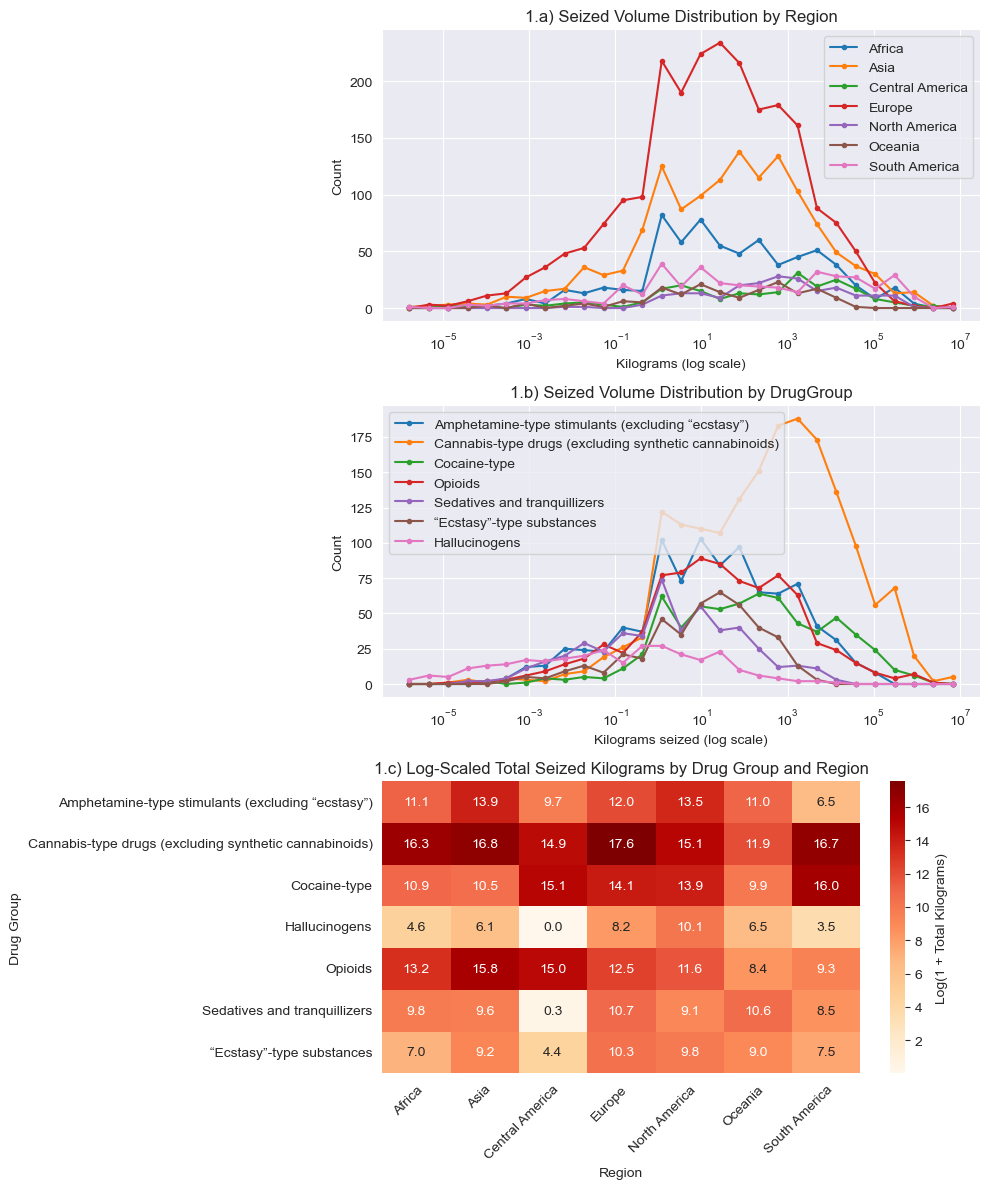

In [31]:
# Define bins for Kilograms using log scale
bins = np.logspace(np.log10(final_seizures_df['seizure_volume'].min() + 1e-6), np.log10(final_seizures_df['seizure_volume'].max()), 30)

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot for Region
for region in final_seizures_df['region'].unique():
    counts, _ = np.histogram(final_seizures_df[final_seizures_df['region'] == region]['seizure_volume'], bins=bins)
    bin_centers = np.sqrt(bins[:-1] * bins[1:])
    ax1.plot(bin_centers, counts, marker='o', linestyle='-', markersize=3, label=region)
ax1.set_xlabel('Kilograms (log scale)')
ax1.set_ylabel('Count')
ax1.set_xscale('log')
ax1.set_title('1.a) Seized Volume Distribution by Region')
ax1.legend()

# Plot for DrugGroup
for drug_group in final_seizures_df['drug_group'].unique():
    counts, _ = np.histogram(final_seizures_df[final_seizures_df['drug_group'] == drug_group]['seizure_volume'], bins=bins)
    bin_centers = np.sqrt(bins[:-1] * bins[1:])
    ax2.plot(bin_centers, counts, marker='o', linestyle='-', markersize=3, label=drug_group)
ax2.set_xlabel('Kilograms seized (log scale)')
ax2.set_ylabel('Count')
ax2.set_xscale('log')
ax2.set_title("1.b) Seized Volume Distribution by DrugGroup")
ax2.legend()

# Plot the relation: Heatmap of total Kilograms by DrugGroup and Region
# Pivot the table to get total kilograms for each DrugGroup and Region combination
try:
    pivot_table = final_seizures_df.pivot_table(
        values='seizure_volume',
        index='drug_group',
        columns='region',
        aggfunc='sum',  # Sum of kilograms
        fill_value=0    # Fill missing combinations with 0
    )

    # Transform the pivot_table to a log scale for the heatmap
    # Using np.log1p to handle potential zeros (log(1+x))
    # This ensures that 0 values become log(1) = 0, and small positive values are handled appropriately.
    log_pivot_table = np.log1p(pivot_table)

    # Plot the heatmap on ax3 using the log-scaled data
    if not log_pivot_table.empty: # Check the transformed table
        sns.heatmap(log_pivot_table, annot=True, fmt=".1f", cmap="OrRd", ax=ax3, cbar_kws={'label': 'Log(1 + Total Kilograms)'})
        ax3.set_title('1.c) Log-Scaled Total Seized Kilograms by Drug Group and Region') # Updated title for clarity
        ax3.set_xlabel('Region')
        ax3.set_ylabel('Drug Group')
        # Rotate x-axis labels for better readability if there are many regions
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    else:
        ax3.text(0.5, 0.5, "Not enough data to create log-scaled heatmap", ha='center', va='center') # Updated message

except Exception as e:
    ax3.text(0.5, 0.5, f"Error creating heatmap: {e}", ha='center', va='center', wrap=True)
    
# Adjust layout
plt.tight_layout()
plt.show()

### Summary:
#### Figure 1.a:

From the distribution we can see that **largest mass** of drug seizures was reported in **Europe**, we think this is due to one of the following reasons:

1. European countries may be more politically inclined to report such incidents.
2. Europe's economic strength may affect the number of potential clients. However, we do need to consider that wealth doesn't mean people are more incline to purchase drugs.
3. Due to the Schengen agreement, it is relatively easier to transport drugs across the region. 
4. Europe's sentencing is less severe (in most cases) than other regions (several years in jail vs. death sentences).

Furthermore - if we aggregate all the regions in America, we will probably see that it'll have a massive lead in larger quantities caught.

#### Figure 1.b:

Key points from the distribution of volume by drug group are the following:

1. There is a large surge in volume after the 2-3 kilogram mark. We speculate that it is harder to seize drugs in low quantities or it is just not reported as frequently.
2. We see that the **most popular** drug-type that is being confiscated is **cannabis** - which is probably due to its popularity and because it is considered a "light" drug - which means it is more likely to be decriminalized or get a less harsh sentence. Moreover, it is produced in many countries, some of them in industrial scale of production (unlike most other drug types where any production is illegal).
3. There are shifts in the 2nd most popular drug between amphetamines, opioids and cocaine. Notably in higher quantities **cocaine** seems to be the most prevalent. This could indicate the production of cocaine is more massive and/or the demand for it is larger.

#### Figure 1.c:

When studying the relationship between Region and drug_group we see some correlation between the region of production of the drug and the region of the seizures.
<BR>
For example - Cocaine is predominantly produced in South American countries like Colombia. Likewise, opioids are manufactured at scale in countries in Asia such as Afghanistan.
<BR>
This could indicate one of two possibilities, or both:
1. Drugs traffickers are getting caught in the countries of production.
2. The drug trade is less global as we thought.

<BR>

**Note** - For future analysis, we do want to see what is the effect in countries with some legalization status (decriminalization at the least) on their cannabis traffic.


---

## sub-section 4.2 - legalization.csv

### 4.2.1 - Country categorization:
In order to examine how legislation on the subject of cannabis affects drug follow in the respected countries, we first devise the following 4 groups of countries, and their current legal state on cannabis (see the table below):

| Category | Category abbreviation | Recreational legal status | Medical legal status |
| --- |-----------------------|---------------------------|----------------------|
| Prohibition | ILL                   | Illegal                   | Illegal              |
| Decriminialized | DEC |  Decriminalized           | Illegal              |
| Medically legal | MED | Decriminalized/Illegal | Legal/CBD only       |
| Full legality | LGL | Legal | Legal                |

**Note** - For decriminalization policies - we do have to differentiate between the volume of drugs one citizen can have have on his possession, as it will be accounted for when pairing it with the drug seizures data. Mainly, we speculate that some of these incidents may not be recorded due to this.

Additionally, we will also remove the 'Notes' as it is no longer necessary after the manual processing in [Section 3](#section-3-manual-feature-engineering-for-legalizationcsv)
We also need to dismiss of North Korea, as they're the only country with the value of 'Unknown' (Probably since they did not disclose information to the UN)

Finally - we arrange, rename according to the schema and the columns and remove unnecessary columns - _Notes_, _Recreational_ and _Medical_

In [13]:
def legal_status_categorization(row: pd.Series) -> str:
    """A simple switch case to categorize a pandas dataframe row to one of 4 categories:
    1. LGL - 'Recreational' column has the value 'Legal'.
    2. MED - 'Recreational' column is either 'Illegal' or 'Decriminalized', and 'Medical' column has one of the following values: 'Legal' or 'CBD only'.
    3. DEC - 'Recreational' column has the value 'Decriminalized'. 'Medical' has the value 'Illegal'.
    4. ILL - 'Recreational' and 'Medical' columns both have the value 'Illegal'.
    """
    if row['Recreational'] == 'Legal':
        return 'LGL'
    elif row['Medical'] in ['CBD only', 'Legal']:
        return 'MED'
    elif row['Recreational'] == 'Decriminalized' and row['Medical'] == 'Illegal':
        return 'DEC'
    else:
        return 'ILL'

legalization_df['legal_category'] = legalization_df.apply(lambda row: legal_status_categorization(row), axis=1)
# Drop rows with 'Unknown' values
legalization_df = legalization_df.query('Recreational != "Unknown" | Medical != "Unknown"')

# reorder the columns for better visualization:
col_name_mapping = {
    "Country/Territory": "country",
    "Recreational_year": "recreational_year",
    "Mediacal_year": "medical_year",
    "Decriminalized_max_possession": "decriminalized_max_possession"
}
column_order = legalization_df.columns.tolist()
column_order.insert(1, 'legal_category')
column_order.pop(len(column_order) - 1)
[column_order.remove(x) for x in ["Recreational", "Medical", "Notes"]]
legalization_df_sorted = legalization_df[column_order]
legalization_df_sorted.rename(columns=col_name_mapping, inplace=True)
legalization_df_sorted.sample(10, random_state=SEED-2).sort_values("legal_category")

C:\Users\User\AppData\Local\Temp\ipykernel_22716\2963063287.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legalization_df_sorted.rename(columns=col_name_mapping, inplace=True)


,country,legal_category,recreational_year,medical_year,decriminalized_max_possession
5,Antigua and Barbuda,DEC,NaN,NaN,NaN
117,Moldova,DEC,NaN,NaN,NaN
54,Estonia,DEC,NaN,NaN,7.5
97,Latvia,ILL,NaN,NaN,1.0
184,Turkmenistan,ILL,NaN,NaN,NaN
161,Singapore,ILL,NaN,NaN,NaN
90,Kiribati,ILL,NaN,NaN,NaN
192,Uzbekistan,ILL,NaN,NaN,NaN
35,Colombia,MED,NaN,2009.0,22.0
135,Pakistan,MED,NaN,2020.0,NaN


#### 4.2.2 - Changes in legalization legislation over time
The following plots display the amount of countries that adopted the policy type.
Figure 2.a displays the adoption of cannabis legalization for medical use (even if it is for a specific substance, like CBD),
and figure 2.b shows the same notion but for recreational use of cannabis.
We have highlighted the years 2018–2022, as they are bounded by these years in the *seizures* dataset.

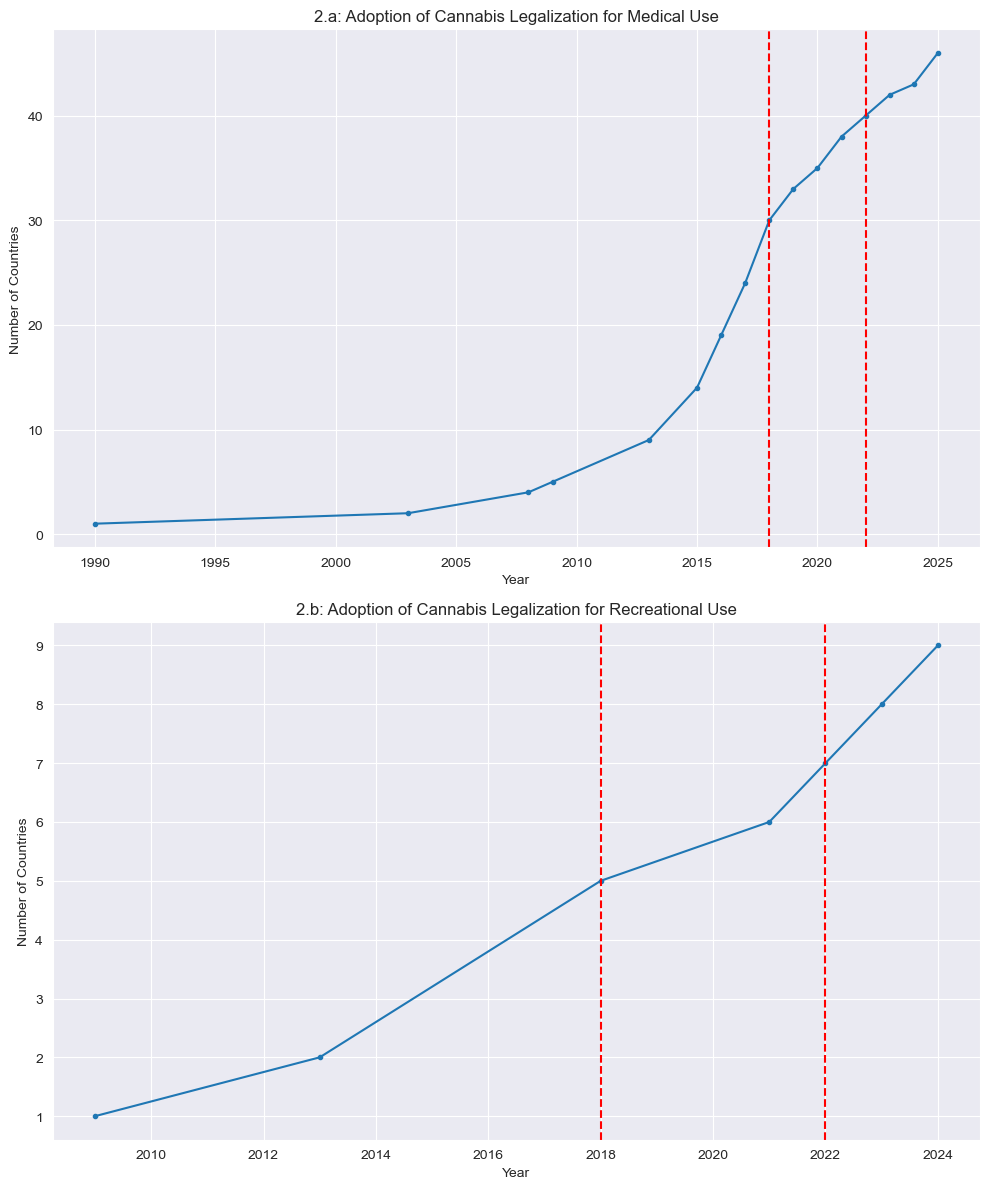

In [14]:
# Filter for medical use legalization and count cumulative sum
med_adoption = legalization_df_sorted[legalization_df_sorted['legal_category'] == 'MED'].groupby('medical_year').size().sort_index().cumsum()

# Filter for recreational use legalization and count cumulative sum
rec_adoption = legalization_df_sorted[legalization_df_sorted['legal_category'] == 'LGL'].groupby('recreational_year').size().sort_index().cumsum()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Subplot 2.a: Medical Use Legalization
ax1.plot(med_adoption.index, med_adoption.values, marker='o', linestyle='-', markersize=3)
ax1.axvline(x=2018, color='r', linestyle='--')
ax1.axvline(x=2022, color='r', linestyle='--')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Countries')
ax1.set_title('2.a: Adoption of Cannabis Legalization for Medical Use')
ax1.grid(True)

# Subplot 2.b: Recreational Use Legalization
ax2.plot(rec_adoption.index, rec_adoption.values, marker='o', linestyle='-', markersize=3)
ax2.axvline(x=2018, color='r', linestyle='--')
ax2.axvline(x=2022, color='r', linestyle='--')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Countries')
ax2.set_title('2.b: Adoption of Cannabis Legalization for Recreational Use')
ax2.grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

#### Key points

1) From figure 2.a - we can see that in 2022, there we overall 40 countries that have legalized cannabis for medical uses, 10 of them had been added between 2018-2022 - making them prominent candidates test our hypothesis.
2) From figure 2.b, we infer that we don't have many cases of countries that enacted full legalization of cannabis, having only **9** total countries in 2024. Furthermore, between 2018 and 2022, there was only one country - Malta, that adopted these laws. We do however, see that in 2018 - **3** countries have legalized cannabis for all purposes, so if we could expand the seizure data, we could add these countries to our analysis as well.

---

#### 4.2.3 - Analyzing possession limits distribution for countries with decriminalization policies
We speculate that the distribution might help us find a trend in policy adoption.
Alternatively, help us understand the trends in drug trafficking seizures and criminal arrests incidents.

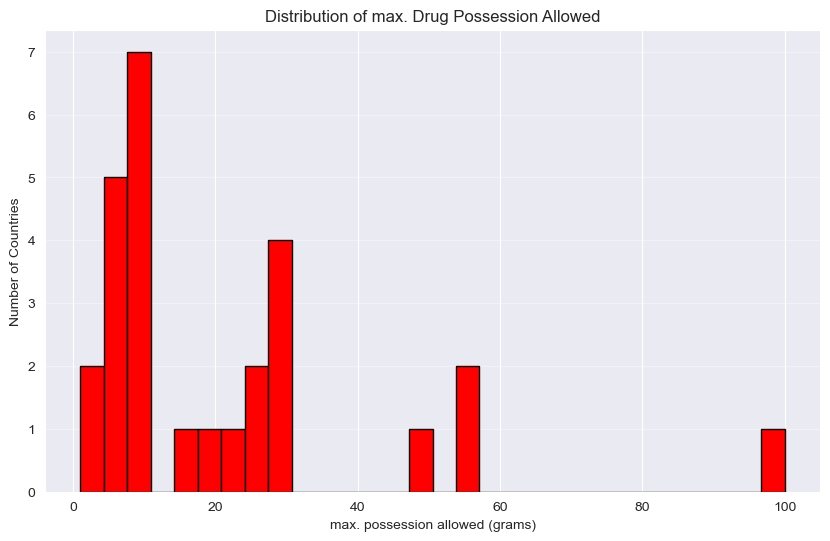

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(legalization_df['Decriminalized_max_possession'].dropna(), bins=30, color='red', edgecolor='black')
plt.xlabel('max. possession allowed (grams)')
plt.ylabel('Number of Countries')
plt.title('Distribution of max. Drug Possession Allowed')
plt.grid(axis='y', alpha=0.35)

#### Key Notes:
As it could be seen above, most countries consider a 30 gram amount of cannabis possession as a non-criminal offense. This could help us explain the sudden shift in seizures found in [figure 1.b](#figure-1b) for cannabis

---

# Sub-Section 5 - Merging *seizures_df* and *legalzation_df* and EDA

Now that we are done processing each dataset individually, we would want to merge them together like in the following diagram:



After we combine the datasets we will preform some further analysis - potential correlations, splicing etc.


In [16]:
dtypes = set()
for val in final_seizures_df['country'].values:
    dtypes.add(type(val))
print(dtypes)

dtypes = set()
for val in legalization_df_sorted['country'].values:
    dtypes.add(type(val))
print(dtypes)

{<class 'str'>}
{<class 'str'>}


In [17]:
merged_df = final_seizures_df.merge(legalization_df_sorted, on=["country"], how="outer", validate="many_to_one")

In [18]:
merged_df[pd.isna(merged_df['legal_category'])]["country"].unique()

array(['Aruba', 'Bolivia (Plurinational State of)', 'Brunei Darussalam',
       'Cabo Verde', 'China', 'China, Hong Kong SAR', 'China, Macao SAR',
       'China, Taiwan Province of China', 'Czechia', "Côte d'Ivoire",
       'Eswatini', 'Iran (Islamic Republic of)',
       "Lao People's Democratic Republic", 'Republic of Korea',
       'Republic of Moldova', 'Russian Federation', 'State of Palestine',
       'Syrian Arab Republic', 'Timor-Leste', 'Türkiye',
       'United Republic of Tanzania', 'United States of America',
       'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'Zimbabwe'],
      dtype=object)

In [19]:
merged_df.query("seizure_volume.isnull() & legal_category != 'ILL'")["country"].unique()


array(['Bermuda', 'Bolivia', 'Czech Republic', 'Dominica', 'Korea, South',
       'Moldova', 'Rwanda', 'Saint Kitts and Nevis', 'Saint Lucia',
       'Saint Vincent and the Grenadines', 'San Marino', 'Turkey',
       'Vanuatu'], dtype=object)

List of countries/territories that were removed due to missing values:
- <span style="color: #006400;">Aruba (missing legalization status)</span>
- <span style="color: #006400;">Palestine (missing legalization status)</span>
- <font color="green">Bermuda (missing traffic data)</font>
- <font color="green">Dominica (missing traffic data)</font>
- <font color="green">Rwanda (missing traffic data)</font>
- <font color="green">Saint Kitts and Nevis (missing traffic data)</font>
- <font color="green">Saint Lucia (missing traffic data)</font>
- <font color="green">Saint Vincent and the Grenadines (missing traffic data)</font>
- <font color="green">San Marino (missing traffic data)</font>
- <font color="green">Vanuatu (missing traffic data)</font>
- 
Countries that were added to the list after searching their cannabis legality status:
- Gibraltar (ILL)
- Armenia (ILL)

Additionally - we have changed the names of some countries in order to merge the two datasets correctly. We arbitrarily decided to change the names in  *seizure_df*:

| Old name | New name |
| --- | --- |
| Bolivia (Plurinational State of) | Bolivia |
| Brunei Darussalam | Brunei |
| Cabo Verde | Cape Verde |
| China | People's Republic of China (PRC) |
| China, Hong Kong SAR | Hong Kong |
| China, Macau SAR | Macau, SAR of China |
| China, Taiwan Province of China | Taiwan |
| Czechia | Czech Republic |
| Côte d'Ivoire | Ivory Coast |
| Eswatini | Eswatini (Swaziland) |
| Iran (Islamic Republic of) | Iran |
| Lao People's Democratic Republic | Laos |
| Republic of Korea | Korea, South |
| Republic of Moldova | Moldova |
| Russian Federation | Russia |
| Syrian Arab Republic | Syria |
| Timor-Leste | East Timor |
| Türkiye | Turkey |
| United Republic of Tanzania | Tanzania |
| United States of America | United States |
| Venezuela (Bolivarian Republic of) | Venezuela |

In [20]:
country_names_to_change = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Brunei Darussalam": "Brunei",
    "Cabo Verde": "Cape Verde",
    "China": "People's Republic of China (PRC)",
    "China, Hong Kong SAR": "Hong Kong",
    "China, Macau SAR": "Macau, SAR of China",
    "China, Taiwan Province of China": "Taiwan",
    "Czechia": "Czech Republic",
    "Côte d'Ivoire": "Ivory Coast",
    "Eswatini": "Eswatini (Swaziland)",
    "Iran (Islamic Republic of)": "Iran",
    "Lao People's Democratic Republic": "Laos",
    "Republic of Korea": "Korea, South",
    "Republic of Moldova": "Moldova",
    "Russian Federation": "Russia",
    "Syrian Arab Republic": "Syria",
    "Timor-Leste": "East Timor",
    "Türkiye": "Turkey",
    "United Republic of Tanzania": "Tanzania",
    "United States of America": "United States",
    "Venezuela (Bolivarian Republic of)": "Venezuela"
}

final_seizures_df['country'] = final_seizures_df['country'].replace(country_names_to_change)

rows_to_add_to_legalization_df = [
    {"country": "Armenia", "legal_category": "ILL"},
    {"country": "Gibraltar", "legal_category": "ILL"},
]

legalization_df_sorted = pd.concat([legalization_df_sorted, pd.DataFrame(data=rows_to_add_to_legalization_df, columns=legalization_df_sorted.columns)], ignore_index=True)

Repeating the merge sequence after our changes. By using an inner join matching mechanism, we remove all territories with missing information as mentioned above.

In [35]:
merged_df = final_seizures_df.merge(legalization_df_sorted, on=["country"], how="inner")
merged_df.sample(10, random_state=SEED-2).sort_values("legal_category")

,region,country,drug_group,drug_sub_group,seizure_reference_year,seizure_volume,legal_category,recreational_year,medical_year,decriminalized_max_possession
220,Africa,Kenya,Cocaine-type,Cocaine,2020,0.35000,ILL,NaN,NaN,NaN
1666,Asia,Singapore,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),2019,28.00000,ILL,NaN,NaN,NaN
314,Africa,Mauritius,Amphetamine-type stimulants (excluding “ecstasy”),Amphetamine,2018,0.00000,ILL,NaN,NaN,NaN
1589,Asia,Philippines,Cannabis-type drugs (excluding synthetic canna...,Cannabis resin (hashish),2018,4.00000,ILL,NaN,NaN,NaN
3339,Europe,Lithuania,Opioids,Pharmaceutical opioids,2020,4.67350,ILL,NaN,NaN,NaN
564,Africa,South Africa,Cannabis-type drugs (excluding synthetic canna...,Cannabis oil,2021,10.00000,LGL,2018.0,2018.0,NaN
3108,Europe,Ireland,Hallucinogens,Reported total hallucinogens,2020,6.65410,MED,NaN,2019.0,NaN
4623,Oceania,Australia,Cannabis-type drugs (excluding synthetic canna...,Cannabis plants,2022,21395.24729,MED,NaN,2016.0,NaN
354,Africa,Morocco,Amphetamine-type stimulants (excluding “ecstasy”),Amphetamine,2022,504.62500,MED,NaN,2021.0,NaN
3684,Europe,Poland,Cannabis-type drugs (excluding synthetic canna...,Cannabis plants,2020,11860.00000,MED,NaN,2017.0,NaN
